# Samples analysis
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, tree

from functools import partial
from getdist import plots

%matplotlib inline
%load_ext autoreload 
%autoreload 2

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

2024-12-11 21:27:05.017167: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Config and fiduc

In [2]:
# Config
save_dir = os.path.expanduser("~/scratch/pickles/")
config = {
          # Mesh and box parameters
          'mesh_shape':3 * (64,), # int
          'box_shape':3 * (640.,), # in Mpc/h (aim for cell lengths between 1 and 10 Mpc/h)
          # LSS formation
          'a_lpt':0.1,
          'lpt_order':1,
          'precond':3,
          }

# Load and save model
model = FieldLevelModel(**default_config | config)
def get_save_dir(**kwargs):
    dir = os.path.expanduser("~/scratch/pickles/")
    # dir = os.path.expanduser("/lustre/fsn1/projects/rech/fvg/uvs19wt/pickles/")
    dir += f"m{kwargs['mesh_shape'][0]:d}_b{kwargs['box_shape'][0]:.1f}"
    dir += f"_al{kwargs['a_lpt']:.1f}_ao{kwargs['a_obs']:.1f}_lo{kwargs['lpt_order']:d}_pc{kwargs['precond']:d}_ob{kwargs['obs']}/"
    return dir
save_dir = get_save_dir(**model.__dict__)
# print(model)
# model.render(0,1)

if not os.path.exists(save_dir):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    os.mkdir(save_dir)
    model.save(save_dir)    
    pdump(truth, save_dir + "truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir + "truth.p")

model.condition({'obs': truth['obs']})
if model.precond==3:
    model.obs_meshk = truth['obs']
model.block()
# model.render(0,1)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b640.0_al0.1_ao0.5_lo1_pc3_obmesh/


## Analysis

In [5]:
jfn = jit(partial(model.predict, samples=(2,20)))
params = jfn(jr.key(42))
pdump(params, save_dir + "samples_0.p")
params = jfn(jr.key(43))
pdump(params, save_dir + "samples_1.p")
params = jfn(jr.key(44))
pdump(params, save_dir + "samples_2.p")

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

In [20]:
from montecosmo.mcbench import Chains
@jit
def reparam_chains(chains, batch_ndim=2):
    # Nest vmaps
    fn = model.reparam
    for _ in range(batch_ndim):
        fn = vmap(fn)

    chains.data = fn(chains.data)
    return chains

# def thin_chains(chains, thin=1):
#     chains.data = chains.data[

chains = Chains.load_from_runs(save_dir+"samples", 0,2, transforms=reparam_chains, groups=model.groups, labels=model.labels)

Loading: samples, from run 0 to run 2 (included)


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


In [23]:
chains[['cosmo']].print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.31      0.15      0.29      0.10      0.57     64.11      1.01
    sigma8      0.81      0.19      0.81      0.56      1.15    105.79      1.00



Removed no burn in


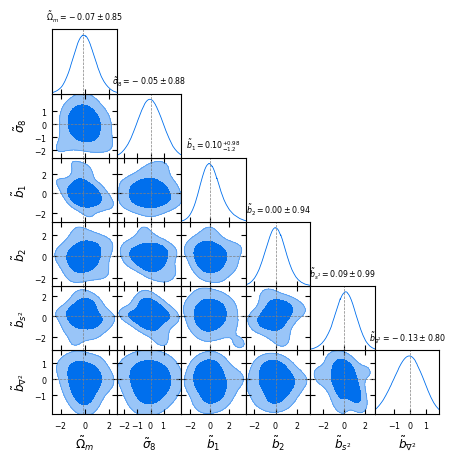

In [42]:
gdsamp = chains[['cosmo_','bias_']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,)

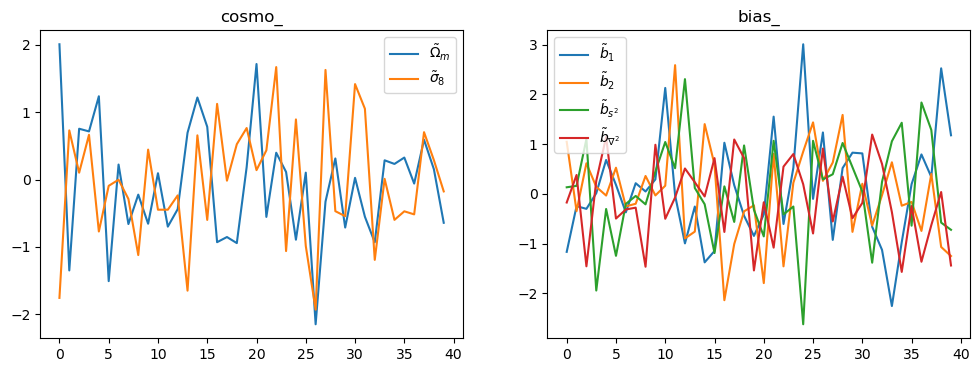

In [43]:
def plot_chains(chains:Chains, groups):
    for i_plt, g in enumerate(groups):
        plt.subplot(1, len(groups), i_plt+1)
        plt.title(g)
        for k,v in chains[[g]].items():
            plt.plot(jnp.concatenate(v, 0), label='$'+chains.labels[k]+'$')
        plt.legend()

plt.figure(figsize=(12, 4))
plot_chains(chains, ['cosmo_', 'bias_'])

In [ ]:
meshes = []
for pc in [0,1,2,3]:
    dir = get_save_dir(**model.__dict__ | {'precond':pc})
    # mesh = jnp.fft.irfftn(pload(dir + "truth.p")['init_mesh'])
    mesh = pload(dir + "truth.p")['obs']
    meshes.append(mesh)